In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os, sys

# 1. Compute the src/ directory (one level up from notebooks/)
notebooks_dir = os.getcwd()                            # e.g. …/graphworld/src/notebooks
src_dir       = os.path.abspath(os.path.join(notebooks_dir, os.pardir))
# 2. Prepend it to Python’s module search path
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# 3. Now you can import as expected
from graph_world.models.basic_gnn import HGCN
print("✅ Imported HGCN from", HGCN)

✅ Imported HGCN from <class 'graph_world.models.basic_gnn.HGCN'>


## Node classification related

In [2]:
import time
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_undirected

from graph_world.models.basic_gnn import GCN, HGCN

# 1) Load Cora
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
data.edge_index = to_undirected(data.edge_index)
device = torch.device("cpu") 
data = data.to(device)

def train_model(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        opt.step()
    return model

def test_model(model, data):
    model.eval()
    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append((pred[mask] == data.y[mask]).float().mean().item())
    return accs  # train, val, test

def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 2) Instantiate & run GCN
gcn = GCN(in_channels=dataset.num_node_features,
          hidden_channels=16,
          num_layers=2,
          out_channels=dataset.num_classes,
          dropout=0.5).to(device)

t0 = time.time()
gcn = train_model(gcn, data)
gcn_time = time.time() - t0
gcn_accs = test_model(gcn, data)

print(f"GCN params: {param_count(gcn):,}  train/val/test = {gcn_accs}  time = {gcn_time:.2f}s")

# 3) Instantiate & run HGCN
hgcn = HGCN(in_channels=dataset.num_node_features,
            hidden_channels=16,
            num_layers=2,
            out_channels=dataset.num_classes,
            c=None,            # learnable curvatures
            manifold='Hyperboloid',
            dropout=0.5,
            bias=True,
            act_name='relu').to(device)

t0 = time.time()
hgcn = train_model(hgcn, data)
hgcn_time = time.time() - t0
hgcn_accs = test_model(hgcn, data)

print(f"HGCN hyperboloid params: {param_count(hgcn):,}  train/val/test = {hgcn_accs}  time = {hgcn_time:.2f}s")


GCN(in_channels = 1433, hidden_channels = 16, out_channels = 7, num_layers=2) 
GCN params: 23,335  train/val/test = [1.0, 0.7120000123977661, 0.718999981880188]  time = 0.90s
HGCN(in=1433, hid=16, layers=2, out=7, manifold=Hyperboloid, c = None)
HGCN hyperboloid params: 23,354  train/val/test = [1.0, 0.734000027179718, 0.7319999933242798]  time = 11.69s


In [ ]:
dataset

TypeError: expected 1 argument, got 0

TypeError: 'Axes' object is not iterable

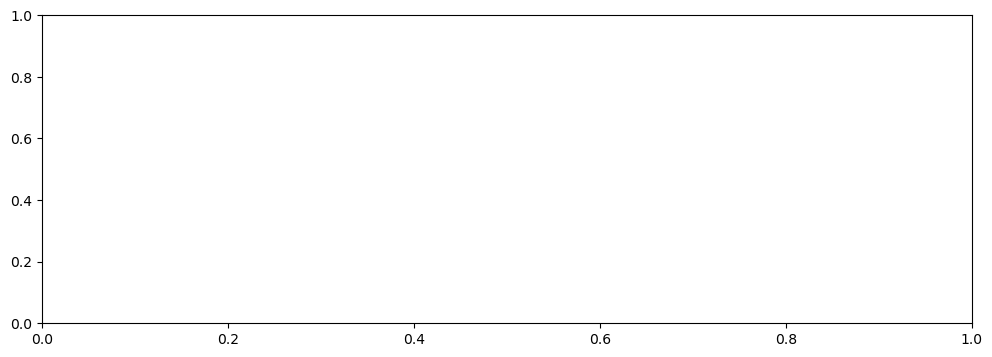

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from graph_world.generators.sbm_simulator import _SimulateHierarchicalFeatures


# === Choose number of nodes & classes ===
N = 400
K = 4
labels = np.random.choice(K, size=N)  # random assignment to 4 classes
D = 16                                # we will generate 16‐dim features

base_d = 2.0    # choose a separation scale
sigma_noise = 1.0

# Values of alpha to test
alphas = [0.8]
titles = ["α=.8 (hier)"]

# Build figure
fig, axes = plt.subplots(1, len(alphas), figsize=(12, 4), sharex=True, sharey=True)

for ax, α, title in zip(axes, alphas, titles):
    X = _SimulateHierarchicalFeatures(
        labels=labels,
        feature_dim=D,
        alpha=α,
        base_distance=base_d,
        noise_variance=sigma_noise,
        # force exactly 2 super‐groups so you see the hierarchy clearly
        num_supergroups=2
    )
    # Reduce to 2D via PCA for plotting
    X2 = PCA(n_components=2).fit_transform(X)

    scatter = ax.scatter(
        X2[:, 0], X2[:, 1],
        c=labels, cmap="tab10", s=20, alpha=0.8,
        edgecolor="k", linewidth=0.3
    )
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Flat→Hierarchical feature interpolation via α", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()


Generating a sample SBM graph...
Graph generated successfully.
Training the model...
Epoch: 000, Loss: 1.4269
Epoch: 020, Loss: 1.1490
Epoch: 040, Loss: 0.8327
Epoch: 060, Loss: 0.6095
Epoch: 080, Loss: 0.4607
Epoch: 100, Loss: 0.3488
Epoch: 120, Loss: 0.2772
Epoch: 140, Loss: 0.2377
Epoch: 160, Loss: 0.2154
Epoch: 180, Loss: 0.2016
Epoch: 200, Loss: 0.1922

Final Model Accuracy: 0.9500
Generating visualizations...


/Users/daniel/miniconda3/envs/graphworld/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


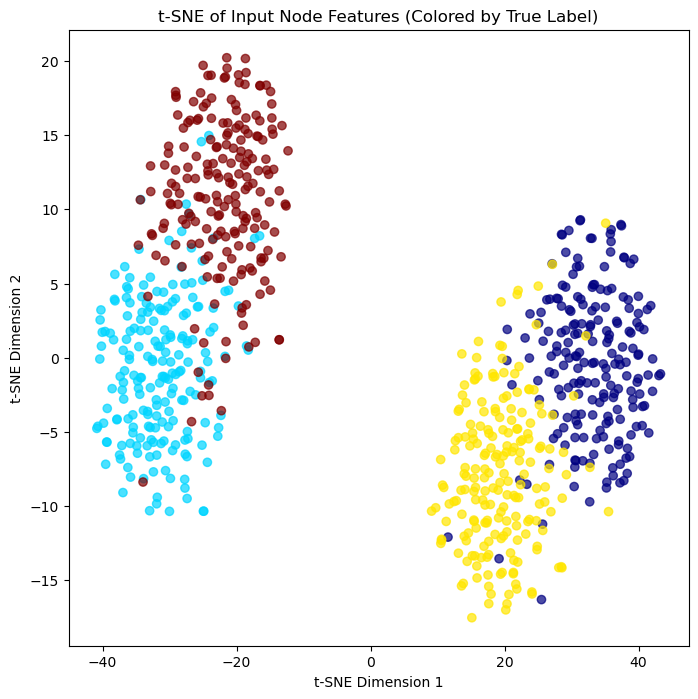

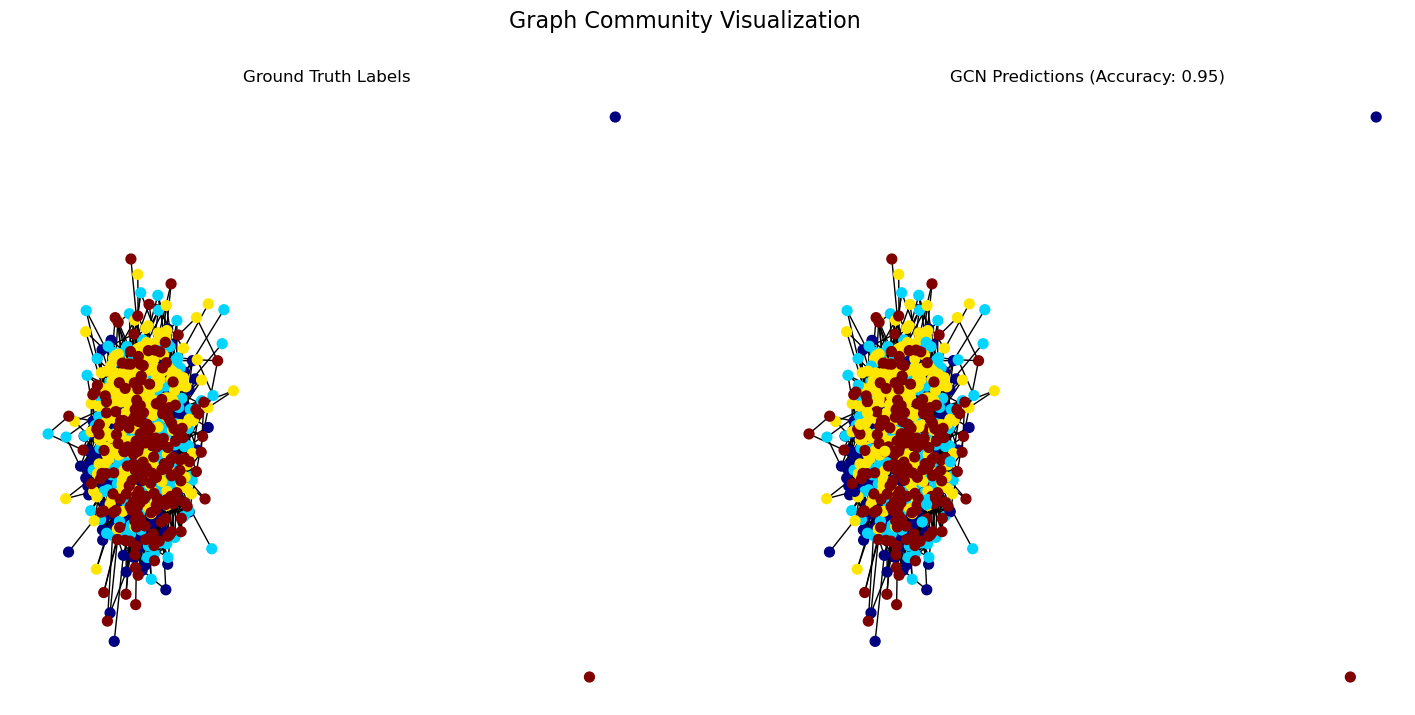

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx

# Make sure to import your SBM simulator functions
from graph_world.generators.sbm_simulator import (
    GenerateStochasticBlockModelWithHierarchicalFeatures,
    MatchType,
    MakePi,
    MakePropMat
)

# --- 1. Generate a "Toy" Graph ---
# We'll use fixed parameters to create an obvious, learnable graph.
print("Generating a sample SBM graph...")

# Parameters for a clear visual example
params = {
    'num_vertices': 800,
    'num_clusters': 4,
    'feature_dim': 16,
    'p_to_q_ratio': 7.0,  # High ratio for distinct communities
    'feature_center_distance': 2.5, # High distance for distinct feature clusters
    'feature_cluster_variance': 1.0, # Low variance for tight feature clusters
    'alpha': .75 # Test the hierarchical interpolation
}

# Generate the graph data
pi = MakePi(params['num_clusters'], community_size_slope=0.0)
prop_mat = MakePropMat(params['num_clusters'], params['p_to_q_ratio'])
sbm_data = GenerateStochasticBlockModelWithHierarchicalFeatures(
    num_vertices=params['num_vertices'],
    num_edges=params['num_vertices'] * 10,
    pi=pi,
    alpha = params['alpha'],
    prop_mat=prop_mat,
    num_feature_groups=params['num_clusters'],
    feature_group_match_type=MatchType.GROUPED,
    feature_dim=params['feature_dim'],
    feature_center_distance= params['feature_center_distance'],
    feature_cluster_variance=params['feature_cluster_variance'],
)

# Convert to PyTorch Geometric Data object
edge_index = torch.tensor(list(sbm_data.graph.get_edges().T), dtype=torch.long)
x = torch.tensor(sbm_data.node_features, dtype=torch.float)
y = torch.tensor(sbm_data.graph_memberships, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

print("Graph generated successfully.")

# --- 2. Define and Train a Simple GCN Model ---
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model and optimizer
model = SimpleGCN(
    in_channels=data.num_node_features,
    hidden_channels=16,
    out_channels=params['num_clusters']
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
print("Training the model...")
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Get final predictions
model.eval()
final_out = model(data.x, data.edge_index)
preds = final_out.argmax(dim=1)
accuracy = torch.sum(preds == data.y).item() / len(data.y)
print(f"\nFinal Model Accuracy: {accuracy:.4f}")

# --- 3. Create Visualizations ---
print("Generating visualizations...")

# Visualization A: t-SNE of Input Features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', n_iter=1000)
features_2d = tsne.fit_transform(data.x.numpy())

plt.figure(figsize=(8, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=data.y.numpy(), cmap='jet', alpha=0.7)
plt.title('t-SNE of Input Node Features (Colored by True Label)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Visualization B: Graph Layout with True vs. Predicted Labels
# Convert PyG data to NetworkX graph for plotting
g_nx = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(g_nx, seed=42) # Force-directed layout

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Ground Truth
axes[0].set_title('Ground Truth Labels')
nx.draw(g_nx, pos, with_labels=False, node_size=50,
        node_color=data.y.numpy(), cmap='jet', ax=axes[0])

# Plot 2: Model Predictions
axes[1].set_title(f'GCN Predictions (Accuracy: {accuracy:.2f})')
nx.draw(g_nx, pos, with_labels=False, node_size=50,
        node_color=preds.numpy(), cmap='jet', ax=axes[1])

plt.suptitle('Graph Community Visualization', fontsize=16)
plt.show()

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_78185/894907790.py:107: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_78185/894907790.py:120: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(markers, [f"G{g}" for g in range(graph_k)],


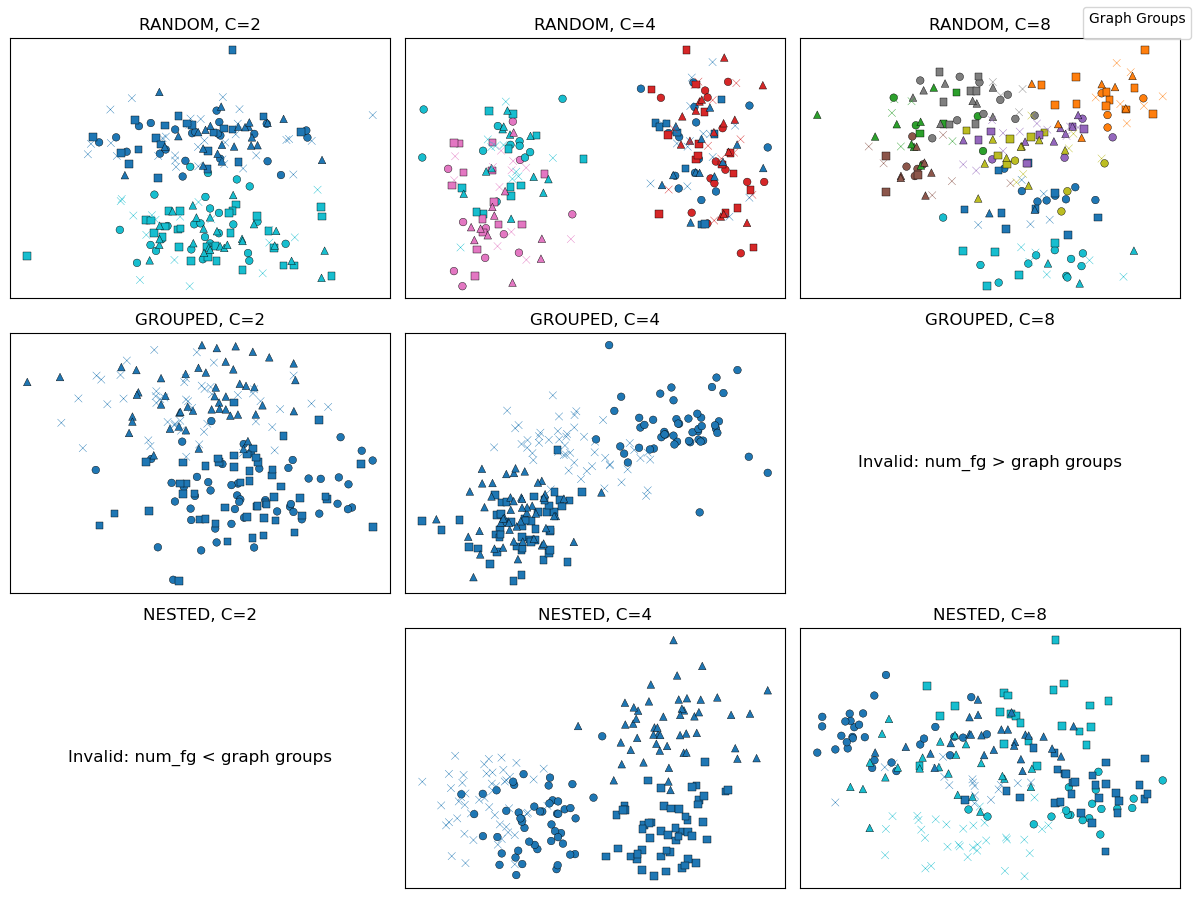

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

def get_nesting_map(large_k, small_k):
    """Replicates the _GetNestingMap behavior."""
    min_multiplicity = large_k // small_k
    max_bloated = large_k - small_k * min_multiplicity - 1
    nesting = {i: [] for i in range(small_k)}
    pos = 0
    for i in range(small_k):
        count = min_multiplicity + (1 if i <= max_bloated else 0)
        for _ in range(count):
            nesting[i].append(pos)
            pos += 1
    return nesting

def generate_feature_memberships(graph_memberships, num_groups, match_type):
    """Simplified version of _GenerateFeatureMemberships logic."""
    graph_k = len(np.unique(graph_memberships))
    n = len(graph_memberships)
    
    if match_type == 'RANDOM':
        return np.random.choice(num_groups, size=n)
    
    elif match_type == 'GROUPED':
        if num_groups > graph_k:
            raise ValueError("GROUPED requires num_groups <= graph groups")
        # feature_cluster -> list of graph_clusters
        nesting = get_nesting_map(graph_k, num_groups)
        # reverse map: graph_cluster -> feature_cluster
        reverse_map = {}
        for fg, glist in nesting.items():
            for g in glist:
                reverse_map[g] = fg
        return np.array([reverse_map[g] for g in graph_memberships])
    
    elif match_type == 'NESTED':
        if num_groups < graph_k:
            raise ValueError("NESTED requires num_groups >= graph groups")
        # graph_cluster -> list of feature_clusters
        nesting = get_nesting_map(num_groups, graph_k)
        memberships = np.zeros(n, dtype=int)
        for g in range(graph_k):
            fclusters = sorted(nesting[g])
            mask = (graph_memberships == g)
            count = mask.sum()
            if len(fclusters) == 1:
                choices = np.full(count, fclusters[0])
            else:
                choices = np.random.choice(fclusters, size=count)
            memberships[mask] = choices
        return memberships
    
    else:
        raise ValueError("Unknown match_type")

# Simulation settings
n_per_group = 50
graph_k = 4
graph_memberships = np.repeat(np.arange(graph_k), n_per_group)
center_var = 5.0     # variance for cluster centers
cluster_var = 1.0    # variance around centers
feature_dim = 2

match_types = ['RANDOM', 'GROUPED', 'NESTED']
num_feature_groups_list = [2, 4, 8]

# Prepare figure
fig, axes = plt.subplots(len(match_types), len(num_feature_groups_list), figsize=(12, 9))

for i, mt in enumerate(match_types):
    for j, num_fg in enumerate(num_feature_groups_list):
        ax = axes[i, j]
        # Check validity
        valid = True
        if mt == 'GROUPED' and num_fg > graph_k:
            valid = False
            msg = "Invalid: num_fg > graph groups"
        if mt == 'NESTED' and num_fg < graph_k:
            valid = False
            msg = "Invalid: num_fg < graph groups"
        
        if not valid:
            ax.text(0.5, 0.5, msg, ha='center', va='center', fontsize=12)
            ax.axis('off')
            ax.set_title(f"{mt}, C={num_fg}")
            continue
        
        # Generate feature memberships
        fg_members = generate_feature_memberships(graph_memberships, num_fg, mt)
        
        # Generate Gaussian centers for each feature cluster
        centers = np.random.randn(num_fg, feature_dim) * np.sqrt(center_var)
        
        # Sample features
        X = np.zeros((len(graph_memberships), feature_dim))
        for idx, fg in enumerate(fg_members):
            X[idx] = centers[fg] + np.random.randn(feature_dim) * np.sqrt(cluster_var)
        
        # Plot: color by feature group, marker by graph group
        markers = ['o', 's', '^', 'x']
        for g in range(graph_k):
            mask = graph_memberships == g
            ax.scatter(
                X[mask, 0], X[mask, 1],
                c=fg_members[mask], cmap='tab10',
                marker=markers[g], s=30,
                edgecolors='k', linewidths=0.3,
                label=f'G{g}' if j == 0 else ""
            )
        
        ax.set_title(f"{mt}, C={num_fg}")
        ax.set_xticks([])
        ax.set_yticks([])

# Global legend for graph groups
fig.legend(markers, [f"G{g}" for g in range(graph_k)],
           title="Graph Groups", loc='upper right')
plt.tight_layout()
plt.show()


## LP related

In [28]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, negative_sampling
from sklearn.metrics import roc_auc_score

# --- Start of Self-Contained Hyperbolic GNN ---

# We will use double precision for stability, as discovered before.
torch.set_default_dtype(torch.float64)

def artanh(x):
    """Numerically stable artanh for PyTorch."""
    # Clamp input to avoid NaNs
    return torch.atanh(x.clamp(-1 + 1e-7, 1 - 1e-7))

def mobius_add(x, y, c):
    """Möbius addition in the Poincaré ball model."""
    x2 = x.pow(2).sum(dim=-1, keepdim=True)
    y2 = y.pow(2).sum(dim=-1, keepdim=True)
    xy = (x * y).sum(dim=-1, keepdim=True)
    num = (1 + 2 * c * xy + c * y2) * x + (1 - c * x2) * y
    denom = 1 + 2 * c * xy + c**2 * x2 * y2
    return num / denom.clamp_min(1e-15)

def poincare_dist_sq(u, v, c):
    """Numerically stable squared distance in the Poincaré ball."""
    sqrt_c = c.sqrt()
    m_add = mobius_add(-u, v, c)
    m_norm = m_add.norm(dim=-1, p=2)
    dist = 2 / sqrt_c * artanh(sqrt_c * m_norm)
    return dist.pow(2).clamp(max=50.0) # Clamp final output

class HyperbolicLayer(nn.Module):
    """A minimal, stable hyperbolic graph layer."""
    def __init__(self, in_features, out_features, c, dropout, use_bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=use_bias)
        self.dropout = nn.Dropout(p=dropout)
        self.c = c

    def forward(self, x_hyper, adj):
        # 1. Project to tangent space (logmap0)
        sqrt_c = self.c.sqrt()
        x_norm = x_hyper.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
        x_tan = artanh(sqrt_c * x_norm) * x_hyper / (sqrt_c * x_norm)

        # 2. Apply linear transformation & dropout in tangent space
        x_tan_transformed = self.linear(self.dropout(x_tan))

        # 3. Aggregate in tangent space
        x_tan_agg = torch.matmul(adj, x_tan_transformed)

        # --- THE FIX: Use tanh for a stable, non-destructive activation ---
        # 4. Apply activation function to the aggregated result
        x_tan_activated = torch.tanh(x_tan_agg)
        # ---------------------------------------------------------------

        # 5. Project back to hyperbolic space (expmap0)
        x_tan_activated_norm = x_tan_activated.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
        new_x_hyper = torch.tanh(sqrt_c * x_tan_activated_norm) * x_tan_activated / (sqrt_c * x_tan_activated_norm)
        
        # Final projection to ensure we stay in the ball
        new_x_hyper_norm = new_x_hyper.norm(dim=-1, p=2, keepdim=True)
        max_norm = (1 - 1e-7) / sqrt_c
        cond = new_x_hyper_norm > max_norm
        projected = new_x_hyper / new_x_hyper_norm * max_norm
        return torch.where(cond, projected, new_x_hyper)

class MinimalHGCN(nn.Module):
    """Our clean-room implementation of a Hyperbolic GCN."""
    def __init__(self, in_features, hidden_features, num_layers, dropout):
        super().__init__()
        self.c = nn.Parameter(torch.tensor([1.0])) # Learnable curvature
        self.initial_embedding = nn.Linear(in_features, hidden_features)
        
        layers = []
        for _ in range(num_layers):
            layers.append(HyperbolicLayer(hidden_features, hidden_features, self.c, dropout))
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x, adj):
        # Initial projection to hyperbolic space
        x_tan = self.initial_embedding(x)
        x_hyper = self.project_to_poincare(x_tan)

        for layer in self.layers:
            x_hyper = layer(x_hyper, adj)
        return x_hyper
    
    def project_to_poincare(self, x_tan):
        """Project vectors from a tangent space at origin to the Poincaré ball."""
        norm = x_tan.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
        sqrt_c = self.c.sqrt()
        # Ensure initial projection is inside the ball
        max_norm = (1 - 1e-5) / sqrt_c
        return torch.tanh(norm) * x_tan / norm * max_norm

class FermiDiracDecoder(nn.Module):
    def __init__(self, r=2.0, t=1.0):
        super().__init__()
        self.r = r
        self.t = t
    def forward(self, z, edge_index, c):
        dist_sq = poincare_dist_sq(z[edge_index[0]], z[edge_index[1]], c)
        dist = dist_sq.sqrt()
        exponent = ((dist - self.r) / self.t).clamp(-50, 50)
        return 1.0 / (torch.exp(exponent) + 1.0)

# --- End of Self-Contained Hyperbolic GNN ---


# 1) Load Data
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
data.x = data.x.to(torch.float64) # Use double precision
# Create a dense adjacency matrix for matrix multiplication
adj = to_dense_adj(data.edge_index)[0]
device = torch.device("cpu")
data.x, adj = data.x.to(device), adj.to(device)

# Create train/val/test splits
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=True, split_labels=True)
train_data, val_data, test_data = transform(data)


# 2) Instantiate Models
model = MinimalHGCN(in_features=dataset.num_node_features, hidden_features=16, num_layers=2, dropout=0.5).to(device)
decoder = FermiDiracDecoder().to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=0.01, weight_decay=0.0)


# 3) Training and Testing Logic
def train():
    model.train()
    decoder.train()
    optimizer.zero_grad()
    
    z = model(data.x, adj)
    
    pos_edges = train_data.pos_edge_label_index
    neg_edges = train_data.neg_edge_label_index
    
    pos_probs = decoder(z, pos_edges, model.c)
    neg_probs = decoder(z, neg_edges, model.c)

    pos_loss = F.binary_cross_entropy(pos_probs.squeeze(), torch.ones_like(pos_probs).squeeze())
    neg_loss = F.binary_cross_entropy(neg_probs.squeeze(), torch.zeros_like(neg_probs).squeeze())
    loss = pos_loss + neg_loss
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    with torch.no_grad():
        model.c.data.clamp_(min=1e-15)
    return float(loss)

@torch.no_grad()
def test(data_split):
    model.eval()
    decoder.eval()
    z = model(data.x, adj)
    pos_probs = decoder(z, data_split.pos_edge_label_index, model.c)
    neg_probs = decoder(z, data_split.neg_edge_label_index, model.c)
    
    probs = torch.cat([pos_probs, neg_probs]).cpu().numpy()
    labels = torch.cat([torch.ones(pos_probs.size(0)), torch.zeros(neg_probs.size(0))]).cpu().numpy()
    
    return roc_auc_score(labels, probs)


# 4) Main training loop with early stopping

print(f"Target AUC from paper: 92.9%")
t0 = time.time()

# --- New variables for patience ---
best_val_auc = 0
final_test_auc = 0
patience = 100
patience_counter = 0
max_epochs = 2000 # We can set a higher max, since patience will stop it
# ---------------------------------

for epoch in range(1, max_epochs + 1):
    loss = train()
    if loss != loss:
        print(f"Stopping training at epoch {epoch} due to NaN loss.")
        break
    
    val_auc = test(val_data)

    # --- Early stopping logic ---
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        # Get the test score for the best validation epoch
        final_test_auc = test(test_data)
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch} as validation AUC did not improve for {patience} epochs.")
        break
    # ----------------------------
    
    if epoch % 10 == 0:
        # Report the current best test score alongside the validation score
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Best Test AUC: {final_test_auc:.4f}, c: {model.c.item():.6f}")


Target AUC from paper: 92.9%
Epoch: 010, Loss: 3.8283, Val AUC: 0.4508, Best Test AUC: 0.4135, c: 0.952963
Epoch: 020, Loss: 2.5688, Val AUC: 0.5092, Best Test AUC: 0.4596, c: 0.947149
Epoch: 030, Loss: 2.1151, Val AUC: 0.5533, Best Test AUC: 0.5000, c: 0.955999
Epoch: 040, Loss: 1.9058, Val AUC: 0.6106, Best Test AUC: 0.5675, c: 0.955811
Epoch: 050, Loss: 1.7512, Val AUC: 0.6812, Best Test AUC: 0.6672, c: 0.925631
Epoch: 060, Loss: 1.4770, Val AUC: 0.7325, Best Test AUC: 0.7178, c: 0.875009
Epoch: 070, Loss: 1.4059, Val AUC: 0.7562, Best Test AUC: 0.7415, c: 0.828680
Epoch: 080, Loss: 1.3561, Val AUC: 0.7631, Best Test AUC: 0.7662, c: 0.784638
Epoch: 090, Loss: 1.2786, Val AUC: 0.7732, Best Test AUC: 0.7900, c: 0.756278
Epoch: 100, Loss: 1.4093, Val AUC: 0.7602, Best Test AUC: 0.7900, c: 0.725376
Epoch: 110, Loss: 1.2729, Val AUC: 0.7800, Best Test AUC: 0.7859, c: 0.697967
Epoch: 120, Loss: 1.2806, Val AUC: 0.7650, Best Test AUC: 0.7859, c: 0.656541
Epoch: 130, Loss: 1.2215, Val AUC: 

In [8]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCN  # Use the official GCN model
from torch_geometric.transforms import GCNNorm, RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

# Use standard single precision, as the GCN encoder is very stable.
torch.set_default_dtype(torch.float32)

# --- Hyperbolic Math & Decoder ---

def poincare_dist_sq(u, v):
    """
    Calculates squared Poincaré distance.
    Assumes u and v are points in the Poincaré ball.
    """
    # Project to ball just in case, to be safe
    u_norm = u.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
    v_norm = v.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
    u = u / (1 + u_norm)
    v = v / (1 + v_norm)
    
    sq_dist = torch.sum((u - v) ** 2, dim=-1)
    sq_norm_u = torch.sum(u ** 2, dim=-1)
    sq_norm_v = torch.sum(v ** 2, dim=-1)
    
    denominator = (1 - sq_norm_u).clamp_min(1e-7) * (1 - sq_norm_v).clamp_min(1e-7)
    gamma = 1 + 2 * sq_dist / denominator
    
    # Clamp input to acosh to avoid NaNs
    dist = torch.acosh(gamma.clamp_min(1.0 + 1e-7))
    return dist.pow(2)

class PoincareDistanceDecoder(nn.Module):
    """Decodes links by calculating Poincaré distance."""
    def __init__(self, r=2.0, t=1.0):
        super().__init__()
        self.r = r
        self.t = t

    def forward(self, z, edge_index):
        emb_in = z[edge_index[0]]
        emb_out = z[edge_index[1]]
        
        # Project embeddings into the ball before calculating distance
        emb_in = emb_in / (1 + emb_in.norm(dim=-1, p=2, keepdim=True)).clamp_min(1e-15)
        emb_out = emb_out / (1 + emb_out.norm(dim=-1, p=2, keepdim=True)).clamp_min(1e-15)

        dist_sq = poincare_dist_sq(emb_in, emb_out)
        dist = dist_sq.sqrt()
        
        exponent = ((dist - self.r) / self.t).clamp(-50, 50)
        return 1.0 / (torch.exp(exponent) + 1.0)

# 1) Load Data
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
device = torch.device("cpu")
data = data.to(device)

# Create train/val/test splits first
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=True, split_labels=True)
train_data, val_data, test_data = transform(data)

# --- THE FIX: Normalize ONLY the training graph ---
# We will use this graph structure for all encoding steps
norm_train_data = GCNNorm(add_self_loops=True)(train_data)


# 2) Instantiate Models: GCN Encoder + Hyperbolic Decoder
# Use a standard GCN as the encoder for guaranteed stability
model = GCN(
    in_channels=dataset.num_node_features,
    hidden_channels=16,
    num_layers=2,
    out_channels=16, # The final embedding dimension
    dropout=0.5,
    act='relu'
).to(device)

decoder = PoincareDistanceDecoder(r=2.0, t=1.0).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=0.01, weight_decay=0.001)


# 3) Training and Testing Logic
def train():
    model.train(); decoder.train()
    optimizer.zero_grad()
    # The official GCN forward pass correctly handles edge_weight
    z = model(norm_train_data.x, norm_train_data.edge_index)
    
    pos_edges = train_data.pos_edge_label_index
    neg_edges = negative_sampling(pos_edges, num_nodes=z.size(0), num_neg_samples=pos_edges.size(1))
    
    pos_probs = decoder(z, pos_edges)
    neg_probs = decoder(z, neg_edges)

    pos_loss = F.binary_cross_entropy(pos_probs, torch.ones_like(pos_probs))
    neg_loss = F.binary_cross_entropy(neg_probs, torch.zeros_like(neg_probs))
    loss = pos_loss + neg_loss
    
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data_split):
    model.eval(); decoder.eval()
    z = model(norm_train_data.x, norm_train_data.edge_index)
    pos_probs = decoder(z, data_split.pos_edge_label_index)
    neg_probs = decoder(z, data_split.neg_edge_label_index)
    
    probs = torch.cat([pos_probs, neg_probs]).cpu().numpy()
    labels = torch.cat([torch.ones(pos_probs.size(0)), torch.zeros(neg_probs.size(0))]).cpu().numpy()
    
    if len(np.unique(labels)) < 2:
        return 0.5
    return roc_auc_score(labels, probs)


# 4) Main training loop
best_val_auc = 0
final_test_auc = 0
patience = 100
patience_counter = 0
for epoch in range(1, 1001):
    loss = train()
    if loss != loss:
        print(f"Stopping training at epoch {epoch} due to NaN loss.")
        break
    
    val_auc = test(val_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test(test_data)
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}.")
        break
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Best Test AUC: {final_test_auc:.4f}")

print("\n--- Final Results ---")
print(f"Final Test AUC score from best validation epoch: {final_test_auc*100:.2f}%")

Epoch: 010, Loss: 1.4067, Val AUC: 0.8696, Best Test AUC: 0.8575
Epoch: 020, Loss: 1.3245, Val AUC: 0.8733, Best Test AUC: 0.8646
Epoch: 030, Loss: 1.2903, Val AUC: 0.8740, Best Test AUC: 0.8710
Epoch: 040, Loss: 1.2680, Val AUC: 0.8721, Best Test AUC: 0.8710
Epoch: 050, Loss: 1.2723, Val AUC: 0.8736, Best Test AUC: 0.8710
Epoch: 060, Loss: 1.2562, Val AUC: 0.8760, Best Test AUC: 0.8781
Epoch: 070, Loss: 1.2514, Val AUC: 0.8787, Best Test AUC: 0.8817
Epoch: 080, Loss: 1.2502, Val AUC: 0.8812, Best Test AUC: 0.8866
Epoch: 090, Loss: 1.2411, Val AUC: 0.8808, Best Test AUC: 0.8866
Epoch: 100, Loss: 1.2425, Val AUC: 0.8825, Best Test AUC: 0.8886
Epoch: 110, Loss: 1.2389, Val AUC: 0.8834, Best Test AUC: 0.8908
Epoch: 120, Loss: 1.2321, Val AUC: 0.8826, Best Test AUC: 0.8908
Epoch: 130, Loss: 1.2381, Val AUC: 0.8811, Best Test AUC: 0.8908
Epoch: 140, Loss: 1.2341, Val AUC: 0.8796, Best Test AUC: 0.8908
Epoch: 150, Loss: 1.2322, Val AUC: 0.8791, Best Test AUC: 0.8908
Epoch: 160, Loss: 1.2305,